In [ ]:
import skimage
from skimage import io
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import numpy as np
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from skimage import measure
import matplotlib.patches as patches
import pytesseract
import re
from icecream import ic
import cv2
from skimage import io, color
from CIEDE2000_git.ciede2000 import CIEDE2000
from icecream import ic
import torchvision
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import h5py
from collections import defaultdict
import pandas as pd
import warnings
import math
from scipy import stats
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
def mark_class_preprocessing(image_path, shape):
    # opens the image
    img = skimage.io.imread(image_path)

    #converts it to grayscale if needed
    if len(img.shape) == 3:
        #reshape image to 1d
        if img.shape[2] == 4:
            img = skimage.color.rgba2rgb(img)
        #if img.shape[2] == 3:
            #img = skimage.color.rgb2gray(img)
    else:
        img = np.dstack([img,img,img])
    
    # expands the image to a square shape
    height, width = img.shape[0],img.shape[1]
    if width == height:
        pass
    elif width > height:
        missing = int((width - height) / 2)
        img = np.pad(img, ((missing, missing), (0, 0),(0, 0)))
    else:
        missing = int((height - width) / 2)
        img = np.pad(img, ((0, 0), (missing, missing),(0, 0)))

    # resizes the image to shape x shape
    img = skimage.transform.resize(img, (shape, shape), anti_aliasing=True)

    return np.array(img)

In [3]:
#this is the preprocessing pipeline as described in the paper Euroviz
def text_local_preprocessing(image_path):
    
    #opens the image
    img = io.imread(image_path)
    
    #expands the image to a square shape
    height, width,d = img.shape
    if width == height:
        pass
    elif width > height:
        missing = int((width - height)/2)
        img = np.pad(img,((missing,missing),(0,0),(0,0)))
    else:
        missing = int((height - width)/2)
        img = np.pad(img,((0,0),(missing,missing),(0,0)))
        
    #resizes the image to 1200x1200
    img = resize(img, (1200,1200, 4),anti_aliasing=True)

    #binarizing the image, otsus method is not made for color, but i think they did it that way and it looks like its working
    thresh = threshold_otsu(img)
    binary = img > thresh
    img[binary] = int(1)
    return img

In [4]:
def get_heatmap(processed_img,net):
    """this function calculates the heatmap, by using the parameters:
    processed_img = an image which was processed by the function 'preprocessing'
    net = the net which is used to generate the heatmap"""
    grayscale = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img))
    res_gray = resize(grayscale, (255,255),anti_aliasing=True)
    inp = torch.from_numpy(np.array(res_gray.reshape(1,1,255,255),dtype=np.float32))
    heatmap = net(inp)
    return heatmap

In [5]:
def apply_heatmap(heatmap, processed_img, contour_param = 0.2,contour_edge = np.inf):
    #this function uses the heatmap to remove non text pixels
    big_heatmap = resize(heatmap.detach().numpy() , (1,1,1200,1200),order=0,anti_aliasing=False).reshape(1200,1200)
    
    #instead of just using a bitwise and operation like in the paper by poco and heer i decided to use 
    # contour lines with a very forgiving contour parameter and some extra added box height and weight 
    # to remove text pixels
    mask_arr = np.zeros((1200,1200))
    contours = measure.find_contours(big_heatmap.reshape(1200,1200),contour_param,"low")
    for contour in contours:
        x = contour[:, 1]
        y = contour[:, 0]

        width = (x.max()-x.min())
        height = (y.max()-y.min())

        h_add_div = contour_edge
        w_add_div = contour_edge
        x_min = max(0,int(x.min() - width/w_add_div))
        x_max = min(1200,int(x.max() + width/w_add_div))
        y_min = max(0,int(y.min() - height/h_add_div))
        y_max = min(1200,int(y.max() + height/h_add_div))

        mask_arr[y_min:y_max,x_min:x_max] = 1
        
    processed_img[mask_arr == 0] = 0
    return processed_img

In [6]:
def get_bb(processed_img):
    
    #in this step i use a connected components algorithm to create bounding boxes around connected components
    grayscale = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img))
    img=np.array(grayscale<=0.9999, dtype = np.int8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img,8,cv2.CV_32S)
    
    #filtering the boxes
    bb = []
    for x,y,w,h,a in stats:
        x_min = x
        x_max = x+w
        y_min = y
        y_max = y+h
        #checking the aspect ratio and removing some boxes if needed
        if 1/10 <= w/h <= 10:
            if 4 <= a <= 4000:#changed 1000 to 4000, because it brings better results
                bb.append([x,y,w,h,a])

    return np.array(bb), labels

In [7]:
#from:
#https://www.geeksforgeeks.org/kruskals-minimum-spanning-tree-algorithm-greedy-algo-2/

# nodes are the candidate characters
#and the edge weights are the Euclidean distances between bounding box centers

# Python program for Kruskal's algorithm to find
# Minimum Spanning Tree of a given connected,
# undirected and weighted graph

from collections import defaultdict

# Class to represent a graph


class Graph:

    def __init__(self, vertices):
        self.V = vertices # No. of vertices
        self.graph = [] # default dictionary
        # to store graph

    # function to add an edge to graph
    def addEdge(self, u, v, w):
        self.graph.append([u, v, w])
        #self.m_graph.append([node1, node2, weight])

    # A utility function to find set of an element i
    # (uses path compression technique)
    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])

    # A function that does union of two sets of x and y
    # (uses union by rank)
    def union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)

        # Attach smaller rank tree under root of
        # high rank tree (Union by Rank)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot

        # If ranks are same, then make one as root
        # and increment its rank by one
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

    # The main function to construct MST using Kruskal's
        # algorithm
    def KruskalMST(self):

        result = [] # This will store the resultant MST

        # An index variable, used for sorted edges
        i = 0

        # An index variable, used for result[]
        e = 0

        # Step 1: Sort all the edges in
        # non-decreasing order of their
        # weight. If we are not allowed to change the
        # given graph, we can create a copy of graph
        self.graph = sorted(self.graph,
                            key=lambda item: item[2])
        
        parent = []
        rank = []

        # Create V subsets with single elements
        for node in range(self.V):
            parent.append(node)
            rank.append(0)

        # Number of edges to be taken is equal to V-1
        while e < self.V - 1:

            # Step 2: Pick the smallest edge and increment
            # the index for next iteration
            u, v, w = self.graph[i]
            i = i + 1
            x = self.find(parent, u)
            y = self.find(parent, v)

            # If including this edge doesn't
            # cause cycle, include it in result
            # and increment the indexof result
            # for next edge
            if x != y:
                e = e + 1
                result.append([u, v, w])
                self.union(parent, rank, x, y)
            # Else discard the edge

        minimumCost = 0
        #print ("Edges in the constructed MST")
        for u, v, weight in result:
            minimumCost += weight
            #print("%d -- %d == %d" % (u, v, weight))
        #print("Minimum Spanning Tree" , minimumCost)
        return result

In [8]:
def create_MST(bb):
    #this fits an MST with krauksals algorithm around the bounding boxes
    g = Graph(len(bb))

    for node1 in range(0,len(bb)):
        for node2 in range(0,len(bb)):
            # node1, node2 = vertex name

            #calculating the euclidian distance
            x1,y1,w1,h1,a1 = bb[node1]
            x2,y2,w2,h2,a2 = bb[node2]

            mid1 = np.array([x1+w1/2,y1+h1/2])
            mid2 = np.array([x2+w2/2,y2+h2/2])

            eucl_dist = np.sqrt((mid1[0]-mid2[0])**2+ (mid1[1]-mid2[1])**2)

            #adding the edge to the graph
            g.addEdge(node1, node2, eucl_dist)

    return g.KruskalMST()

In [9]:
def prune(bb,MST,processed_img):
    #pruning the tree:
    
    #pruning edges, which are to long
    length_set = np.array(bb[:,3])#changed the length set, to only include height
    l = np.argmax(np.bincount(length_set,minlength=0))
    cleaned_MST = []
    for i,[node1, node2, weight] in enumerate(MST):
        #discarding edges with >2l l
        if weight <= 1.5*l:
            cleaned_MST.append([node1, node2, weight])
         
    #discarding edges with to much overlap or so i guess
    MST = np.array(cleaned_MST)  
    cleaned_MST = []
    for i in range(len(bb)):
        #calculating overlap
        relevant_edges = MST[(MST[:,0]==i) | (MST[:,1]==i)]
        for node1,node2,weight in relevant_edges:
            x1,y1,w1,h1,a1 = bb[int(node1)]
            x2,y2,w2,h2,a2 = bb[int(node2)]
            hor_over = min(-x1+x2+w2,-x2+x1+w1,w1,w2)
            ver_over = min(-y1+y2+h2,-y2+y1+h1,h1,h2)
            if hor_over>min(w1,w2)/2 or ver_over>min(h1,h2)/2:#what is w1,2,h1,2
                if not [node1,node2,weight] in cleaned_MST:
                    cleaned_MST.append([node1,node2,weight])
    
    #discarding edges with to high color difference
    cleaned_MST = []
    for i in range(len(bb)):
        relevant_edges = MST[(MST[:,0]==i) | (MST[:,1]==i)]
        for node1,node2,weight in relevant_edges:
            x1,y1,w1,h1,a1 = bb[int(node1)]
            x2,y2,w2,h2,a2 = bb[int(node2)]

            processed_img1 = processed_img[y1:y1+h1,x1:x1+w1,]
            grayscale1 = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img1))
            img1=np.array(grayscale1<=0.5, dtype = np.int8)
            num_labels1, labels1, stats1, centroids1 = cv2.connectedComponentsWithStats(img1,8,cv2.CV_32S)
            rgb1 = skimage.color.rgba2rgb(processed_img1[labels1!=0])
            lab1 = color.rgb2lab(rgb1)
            mean1 = np.mean(lab1,axis=0)

            processed_img2 = processed_img[y2:y2+h2,x2:x2+w2,]
            grayscale2 = skimage.color.rgb2gray(skimage.color.rgba2rgb(processed_img2))
            img2=np.array(grayscale2<=0.5, dtype = np.int8)
            num_labels2, labels2, stats2, centroids2 = cv2.connectedComponentsWithStats(img2,8,cv2.CV_32S)     
            rgb2 = skimage.color.rgba2rgb(processed_img2[labels2!=0])
            lab2 = color.rgb2lab(rgb2)
            mean2 = np.mean(lab2,axis=0)

            color_diff = CIEDE2000(mean1,mean2)

            if color_diff <= 20:
                if not [node1,node2,weight] in cleaned_MST:
                    cleaned_MST.append([node1,node2,weight])

    return np.array(cleaned_MST)

In [10]:
#using a connected components algorithm to get word boxes
#https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/

# Python program to print connected
# components in an undirected graph
class CC_Graph:

    # init function to declare class variables
    def __init__(self, V):
        self.V = V
        self.adj = [[] for i in range(V)]

    def DFSUtil(self, temp, v, visited):

        # Mark the current vertex as visited
        visited[v] = True

        # Store the vertex to list
        temp.append(v)

        # Repeat for all vertices adjacent
        # to this vertex v
        for i in self.adj[v]:
            if visited[i] == False:

                # Update the list
                temp = self.DFSUtil(temp, i, visited)
        return temp

    # method to add an undirected edge
    def addEdge(self, v, w):
        self.adj[v].append(w)
        self.adj[w].append(v)

    # Method to retrieve connected components
    # in an undirected graph
    def connectedComponents(self):
        visited = []
        cc = []
        for i in range(self.V):
            visited.append(False)
        for v in range(self.V):
            if visited[v] == False:
                temp = []
                cc.append(self.DFSUtil(temp, v, visited))
        return cc


In [11]:
def create_word_boxes(MST,bb):
    #creates the word boxes by merging boxes wich have connecting edges in the MST
    ccg = CC_Graph(len(bb))

    for n1,n2,w in MST:
        ccg.addEdge(int(n1),int(n2))
    cc = ccg.connectedComponents()
    
    wbb = []
    for c in cc:
        values = []
        for node in c:
            x,y,w,h,a = bb[int(node)]
            values.append([x,y,x+w,y+h])
        values = np.array(values)
        x,y,xw,yh = values[:,0],values[:,1],values[:,2],values[:,3]
        wbb.append([x.min(),y.min(),xw.max()-x.min(),yh.max()-y.min()])
        
    return np.array(wbb)

In [12]:
def ocr(wbb,img,processed_img,req_conf = 25):
    #this function calculates the words in the bounding boxes
    
    all_text = []
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    #this path should be where tesseract is on your computer

    #go through every word box
    used_wbb = []
    for x,y,w,h in wbb:
        a = 5
        if y-a < 0 or y+h+a <0 or x-a <0 or x+w+a<0:
            # crop a word rectangle from the binary image
            a = 0 # a is some extra box width
        text_img = processed_img[y-a:y+h+a,x-a:x+w+a]
        gray = skimage.color.rgb2gray(skimage.color.rgba2rgb(text_img))
        rgb = skimage.color.rgba2rgb(text_img)

        #scale it by a factor of 3
        big_img = resize(text_img, (text_img.shape[0]*3,text_img.shape[1]*3,4),anti_aliasing=True)

        #We run Tesseract multiple times with the image rotated at different angles
        #this part just rotates the image and then takes the rotation, in which tesseract is most confident in
        best_conf = -1
        best_angle = 0
        
        for angle in [0,90,180,270]:
            img = skimage.transform.rotate(rgb,angle,True)
            out = pytesseract.image_to_data((img*255).astype(np.uint8),output_type=pytesseract.Output.DICT,config="--psm 7")
            
            #calculating average confidence if not -1
            n = 0
            summ = 0
            for val in out["conf"]:
                if val != "-1":
                    n+=1
                    summ += float(val)
            if n == 0:
                n = 1
            conf = summ/n
            
            #saving the best confidence
            if best_conf < conf:
                best_conf = conf
                best_angle = angle
        
        #looking for the content and adding the patch
        if best_conf > 25:
            rgb = skimage.transform.rotate(big_img,best_angle,True) 
            img_content = pytesseract.image_to_string((rgb*255).astype(np.uint8),config="--psm 7")#6#7 with rotation #11
            #converting common ocr mistakes to the right letter
            if img_content in ["l","l "," l","|","| "," |","I","I "," I","i","i "," i"]:
                img_content = "1"
            if img_content in ["O","o","O ","o "," O"," o"]:
                img_content = "0"
            all_text.append(img_content)
            used_wbb.append([x,y,w,h])
            
    return all_text, np.array(used_wbb)

In [13]:
#net modeled after:
#https://github.com/domoritz/darknet/blob/master/cfg/writing.cfg

class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        # i decided that all input images will be preprocessed like in the reverse ingeneering paper 
        # to 256x256 such that i dont need the croping layer
        # and i changed the kernel size of the last kernel to get the output of 64x64
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32, kernel_size=[7, 7],stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32, kernel_size=[3, 3],stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=32, kernel_size=[3, 3],stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=1, kernel_size=[2, 2],stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
    def ramp(self,x):
        #ramp activation function
        x[x < -1] = -1
        x[x > 1] = 1
        return x
    
    def forward(self, x):
        x = self.ramp(self.conv1(x))
        x = self.ramp(self.conv2(x))
        x = self.ramp(self.conv3(x))
        x = self.sigmoid(self.conv4(x))
        return x

In [14]:
def calculate_text_class_features(fig_width, fig_height, x_mins, x_maxs, y_mins, y_maxs):
    #this function calculates the features for text role classification
    
    
    # x_min, x_max, y_min, y_max as a np.array of all boxes
    n_boxes = len(x_mins)
    features = np.zeros([n_boxes,10])
    
    #to calculate:
    #norm_x_coordinate
    widths = x_maxs - x_mins
    x_coordinates = widths/2 + x_mins
    features[:,0] = x_coordinates/fig_width
    
    #norm_y_coordinate
    heights = y_maxs - y_mins
    y_coordinates = heights/2 + y_mins
    features[:,1] = y_coordinates/fig_height
    
    #aspect_ratio
    features[:,2] = widths/heights
    
    #quadrant
    quad = np.empty_like(features[:,1])
    for i,(x,y) in enumerate(zip(features[:,0],features[:,1])):
        if x < 0.5 and y < 0.5:
            quad[i] = 0
        elif x >= 0.5 and y < 0.5:
            quad[i] = 1
        elif x >= 0.5 and y >= 0.5:
            quad[i] = 2
        elif x < 0.5 and y >= 0.5:
            quad[i] = 3
    features[:,3] = quad
    
    #norm_cont_h
    cont_h = max(y_maxs) - min(y_mins)
    features[:,4] = cont_h/fig_height
    
    #norm_cont_w
    cont_w = max(x_maxs) - min(x_mins)
    features[:,5] = cont_w/fig_width
    
    #normalized center coordinates relative to the container x
    features[:,6] = (x_coordinates - min(x_mins))/cont_w
    
    #normalized center coordinates relative to the container y
    features[:,7] = (y_coordinates - min(y_mins))/cont_h
    
    #vertical_score and horizontal_score
    h_score = np.empty_like(x_mins)
    
    #vscore is complicated, maybe i should consider direction of the text
    v_score = np.empty_like(x_mins)

    for i,box in enumerate(zip(x_mins, x_maxs, y_mins, y_maxs)):
        h_intersections = 0
        v_intersections = 0

        for boxx in zip(x_mins, x_maxs, y_mins, y_maxs):
            mid_x = (box[1] - box[0])/2 + box[0]
            mid_y = (box[3] - box[2])/2 + box[2]
            x_pixels = box[1] - box[0]
            y_pixels = box[3] - box[2]
            x_pixxels = boxx[1] - boxx[0]
            y_pixxels = boxx[3] - boxx[2]
            if boxx[0] < mid_x < boxx[1]:
                if x_pixels>=y_pixels and x_pixxels>=y_pixxels:
                    h_intersections += 1
                if x_pixels<=y_pixels and x_pixxels<=y_pixxels:
                    h_intersections += 1

            elif boxx[0] < mid_x < boxx[1]:
                if x_pixels>=y_pixels and x_pixxels>=y_pixxels:
                    h_intersections += 1
                if x_pixels<=y_pixels and x_pixxels<=y_pixxels:
                    h_intersections += 1

            
            if boxx[2] < mid_y < boxx[3]:
                if x_pixels>=y_pixels and x_pixxels>=y_pixxels:
                    v_intersections += 1
                if x_pixels<=y_pixels and x_pixxels<=y_pixxels:
                    v_intersections += 1

            elif boxx[2] < mid_y < boxx[3]:
                if x_pixels>=y_pixels and x_pixxels>=y_pixxels:
                    v_intersections += 1
                if x_pixels<=y_pixels and x_pixxels<=y_pixxels:
                    v_intersections += 1

        h_score[i] = h_intersections  
        v_score[i] = v_intersections  
    features[:,8] = (h_score+1)/n_boxes
    features[:,9] = (v_score+1)/n_boxes

    return features

In [15]:
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

pd.options.display.width = 0
from sklearn import svm
    
def train_classifier():
    #this function trains a random forrest classifier on our training data
    
    # go through all files:
    x = []
    y = []
    w = []
    h = []
    fig_width = []
    fig_height = []
    labels = []

    path = os.path.join("your_path","academic") #here should be your path to the text role classification data from 
    # https://drive.google.com/drive/folders/1Bg9hyxlt2szXj6CBWIIt3yInIjKEqPFx
    i = 0
    for file_name in os.listdir(path):
        if file_name[-15:] != "pred1-texts.csv" and file_name[-4:] != ".png":
            df = pd.read_csv(os.path.join(path,file_name))
        if file_name[-4:] == ".png":
            img = io.imread(os.path.join(path,file_name))

            x.append(df["x"].to_numpy())
            y.append(df["y"].to_numpy())
            w.append(df["width"].to_numpy())
            h.append(df["height"].to_numpy())
            fig_width.append([img.shape[1]])
            fig_height.append([img.shape[0]])
            labels.extend(df["type"].to_numpy())
            
    labels = np.array(labels)
    text_labels = labels.copy()
    
    for i,label in enumerate(np.unique(labels)):
        labels[labels==label] = int(i)

    #calculating the right features
    my_features = []
    for i in range(len(x)):
        features = calculate_text_class_features(fig_width[i], fig_height[i], x[i], x[i]+w[i], y[i], y[i]+h[i])
        for row in features:
            my_features.append(row)

    my_features = np.array(my_features)

    data = np.empty([len(my_features),11])
    for i,row in enumerate(data):
        data[i] = np.append(my_features[i],labels[i])

    np.random.shuffle(data)
    #splitting the data
    x_train = data[:int(len(data)*0.8),:-1]
    x_test = data[int(len(data)*0.8):,:-1]

    y_train = data[:int(len(data)*0.8),-1].astype("int")
    y_test = data[int(len(data)*0.8):,-1].astype("int")


    #training the classifier
    clf = RandomForestClassifier()
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    return clf, text_labels

In [16]:
def convert_val(val):
    #this function tries to convert detected values to floats
    
    floats = []
    unit_dict = {"M":1000000,
                 "Mio":1000000,
                "%":0.01}
    
    for v in val:
        try:
            floats.append(float(v))
        except:
            #check if there is maybe a unit in the number
            letters = re.findall('[a-zA-Z]', v)
            letter_str = "".join(letters)
            try:
                multiplier = unit_dict[letter_str]
            except:
                multiplier = 1
            try:
                numbers = float(re.sub('\D','', v))
                floats.append(numbers*multiplier)
            except:
                pass
    return sorted(floats)

val = [' 100 M ---', 'precision', '95M', '06 - ü', '85']
convert_val(val)

[6.0, 85.0, 95000000.0, 100000000.0]

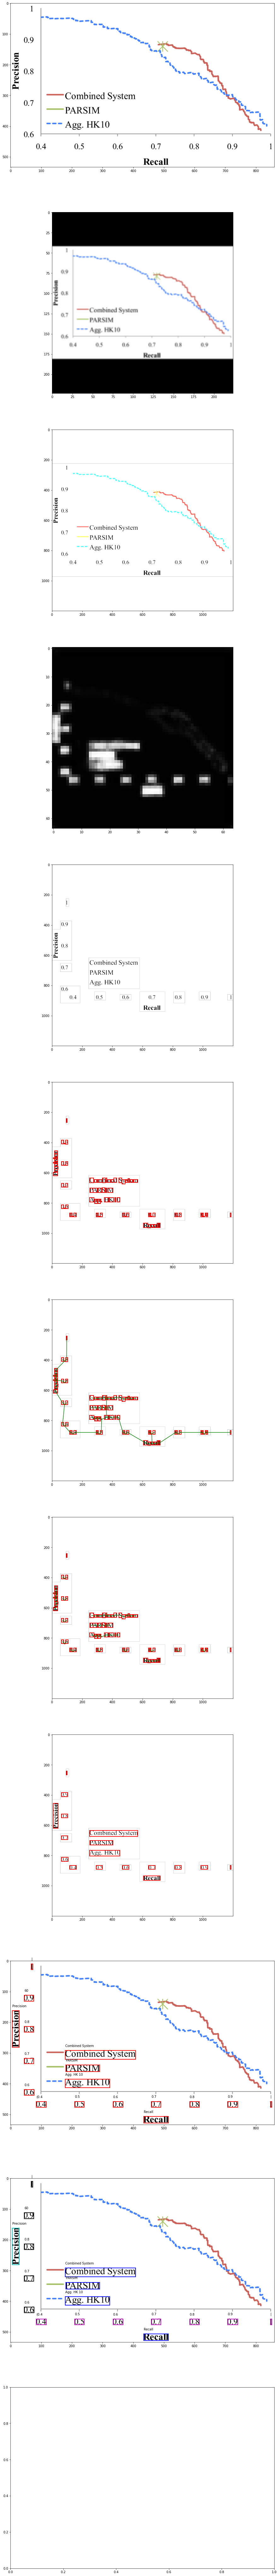

In [17]:
def get_specification(filepath, visualize = True,contour_param = 0.2,contour_edge = np.inf):
    #this function does things as described in the thesis
    
    # general calculations
    fig, ax = plt.subplots(11,1,figsize = (15,150))
    img = io.imread(filepath)
    ax[0].imshow(img)
    height, width,_ = img.shape
    
    #mark type classification #####################################################################################################
    output_size = 224
    mark_preprocessed_img = mark_class_preprocessing(filepath,output_size)
    ax[1].imshow(mark_preprocessed_img)
    
    mark_input = torch.tensor(mark_preprocessed_img.reshape(1,3,224,224),dtype = torch.float32)
    
    #here should be the path to the alexnet for mark type classification
    mark_net = torch.load(os.path.join("NNs","AlexNet_mark_type.pt"),map_location=torch.device('cpu')) #needs input 1, 3, 224, 224
    mark_output = mark_net(mark_input)
    mark_class = torch.argmax(mark_output)
    
    if mark_class == 0:
        chart_type = "bar_chart"
        mark_type = "bar"
    elif mark_class == 1:
        chart_type = "line_chart"
        mark_type = "line"
    elif mark_class == 2:
        chart_type = "scatterplot"
        mark_type = "point"
    elif mark_class == 3:
        chart_type = "area_chart"
        mark_type = "area"

    #text localization ##########################################################################################
    #loading the already trained net
    #net = TextLocalNet()
    net = torch.load(os.path.join("NNs", "domoritz_original_cnn.pt"),map_location=torch.device('cpu'))
    
    local_processed_img = text_local_preprocessing(filepath)
    ax[2].imshow(local_processed_img)
    
    heatmap = get_heatmap(local_processed_img,net)
    ax[3].imshow(heatmap.detach().numpy().reshape(64,64),cmap="gray")
    heat_img = apply_heatmap(heatmap, local_processed_img)
    ax[4].imshow(heat_img)
    
    bb, labels = get_bb(heat_img)
    ax[5].imshow(heat_img, cmap=plt.cm.gray)
    for i in range(0,len(bb)):
        x,y,w,h,area = bb[i, :]
        rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax[5].add_patch(rect)
    
    MST = create_MST(bb)
    ax[6].imshow(heat_img, cmap=plt.cm.gray)
    for i in range(0,len(bb)):
        x,y,w,h,area = bb[i, :]
        rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax[6].add_patch(rect)
    for node1, node2, weight in MST:
        x1,y1,w1,h1,a1 = bb[node1]
        x2,y2,w2,h2,a2 = bb[node2]
        mid1 = np.array([x1+w1/2,y1+h1/2])
        mid2 = np.array([x2+w2/2,y2+h2/2])
        ax[6].plot([mid1[0],mid2[0]],[mid1[1],mid2[1]], color="green")
        
        
    MST = prune(bb,MST,heat_img)
    ax[7].imshow(heat_img, cmap=plt.cm.gray)
    for i in range(0,len(bb)):
        x,y,w,h,area = bb[i, :]
        rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax[7].add_patch(rect)
    for node1, node2, weight in MST:
        x1,y1,w1,h1,a1 = bb[int(node1)]
        x2,y2,w2,h2,a2 = bb[int(node2)]
        mid1 = np.array([x1+w1/2,y1+h1/2])
        mid2 = np.array([x2+w2/2,y2+h2/2])
        ax[7].plot([mid1[0],mid2[0]],[mid1[1],mid2[1]], color="green")
        
    wbb = create_word_boxes(MST,bb)
    ax[8].imshow(heat_img, cmap=plt.cm.gray)
    for i in range(0,len(wbb)):
        x,y,w,h = wbb[i, :]
        rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax[8].add_patch(rect)

    words, wbb = ocr(wbb,heat_img, heat_img)
    

    x,y,w,h = wbb[:,0],wbb[:,1],wbb[:,2],wbb[:,3]
    if width > height:
        scaling_factor = width/1200
        y = y - (1200 - height*(1/scaling_factor))/2
        y = y*scaling_factor
        x = x*scaling_factor
        w = w*scaling_factor
        h = h*scaling_factor
    else:
        scaling_factor = height/1200
        x = x - (1200 - width*(1/scaling_factor))/2
        y = y*scaling_factor
        x = x*scaling_factor
        w = w*scaling_factor
        h = h*scaling_factor

    wbb = np.array([x,y,w,h]).T
    ax[9].imshow(img, cmap=plt.cm.gray)
    for i in range(0,len(words)):
        x,y,w,h = wbb[i, :]
        rect = patches.Rectangle((x,y), w, h, linewidth=2,edgecolor="r", facecolor="none")
        ax[9].add_patch(rect)
        ax[9].text(x,y, words[i])
        
    #text classification #########################################################################################
    df = calculate_text_class_features(height, width, wbb[:,0], wbb[:,0]+wbb[:,2], wbb[:,1], wbb[:,1]+wbb[:,3])

    clf, labels = train_classifier()
    unique_labels = np.unique(labels)
    
    text_class = clf.predict(df)
    

    ax[10].imshow(img, cmap=plt.cm.gray)
    colors = np.array(['b', 'g', 'r', 'gray', 'm', 'y', 'k', 'c'])
    for i in range(0,len(words)):
        x,y,w,h = wbb[i, :]
        class_number = text_class[i]
        rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor=colors[class_number], facecolor="none")#colors[class_number],)
        ax[10].add_patch(rect)
        ax[10].text(x,y, words[i])
       
    
    
    # creating the specification dictionary ########################################################################################
    title = ''
    x_axis_title = ''
    x_axis_labels = []
    y_axis_title = ''
    y_axis_labels = []
    
    #calculating range#######################################################
    x_range = [np.inf,-np.inf]
    y_range = [np.inf,-np.inf]
    for i in range(0,len(wbb)):
        if text_class[i] == np.where(unique_labels == 'legend-title'):
            if words[i][-1:]=="\n":
                title = words[i][:-1]
            else:
                title = words[i]
        elif text_class[i] == np.where(unique_labels == 'x-axis-title'):
            if words[i][-1:]=="\n":
                x_axis_title = words[i][:-1]
            else:
                x_axis_title = words[i]
            
        elif text_class[i] == np.where(unique_labels == 'x-axis-label'):
            if words[i][-1:]=="\n":
                x_axis_labels.append(words[i][:-1])
            else:
                x_axis_labels.append(words[i])
            if x_range[0] > wbb[i][0] + wbb[i][2]/2:
                x_range[0] = wbb[i][0] + wbb[i][2]/2
            if x_range[1] < wbb[i][0] + wbb[i][2]/2:
                x_range[1] = wbb[i][0] + wbb[i][2]/2
            
        elif text_class[i] == np.where(unique_labels == 'y-axis-title'):
            if words[i][-1:]=="\n":
                y_axis_title = words[i][:-1]
            else:
                y_axis_title = words[i]
        elif text_class[i] == np.where(unique_labels == 'y-axis-label'):
            if words[i][-1:]=="\n":
                y_axis_labels.append(words[i][:-1])
            else:
                y_axis_labels.append(words[i])
            if y_range[0] > wbb[i][1] + wbb[i][3]/2:
                y_range[0] = wbb[i][1] + wbb[i][3]/2
            if y_range[1] < wbb[i][1] + wbb[i][3]/2:
                y_range[1] = wbb[i][1] + wbb[i][3]/2
    ######################################################################
    out_dict = {}
    out_dict["width"] = width
    out_dict["height"] = height
    out_dict["chart type"] = chart_type
    out_dict["mark type"] = mark_type
    out_dict["title"] = title
    encoding = {}
    x = {}
    x["field"] = x_axis_title
    x["axis"] = {"title":x_axis_title}
    scale = {}
    scale["labels"] = x_axis_labels
    
            
    scale["values"] = convert_val(x_axis_labels)
    x["type"] = "nominal" if len(scale["values"])<=1 else "quantitive"
    scale["domain"] = [min(scale["values"]),max(scale["values"])] if len(scale["values"]) > 1 else []
    scale["range"] = x_range
    scale["type"] = "undefined"
    
    # trying to check the scale type for the x_axis #####################################################
    if x["type"] == "nominal":
        scale["type"] = "nominal"
    else:
        if scale["values"] == 2:
            scale["type"] = "not defined"
        else:
            #check for linearity
            start = scale["domain"][0]
            end = scale["domain"][1]
            lin_r = stats.linregress(scale["values"], np.linspace(start,end,len(scale["values"])))[2] # gives the rvalue
            if np.abs(lin_r)>=0.98:
                scale["type"] = "linear"
            else:
                #check if logarithmic
                for base in [2,np.e,3,5,10]:
                    stop = math.log(end, base)
                    np.logspace(start, stop, num=len(scale["values"]), base = base)
                    lin_r = stats.linregress(scale["values"], np.logspace(start, stop, num=len(scale["values"]), base = base))[2]
                    if np.abs(lin_r)>=0.98:
                        scale["type"] = "logarithmic"
                        
            
    x["scale"] = scale
    y = {}
    y["field"] = y_axis_title
    y["axis"] = {"title":y_axis_title}
    scale = {}
    scale["labels"] = y_axis_labels
    scale["values"] = convert_val(y_axis_labels)
    y["type"] = "nominal" if len(scale["values"])<=1 else "quantitive"
    scale["domain"] = [min(scale["values"]),max(scale["values"])] if len(scale["values"]) > 1 else []
    scale["range"] = y_range
    scale["type"] = "undefined"

    # trying to check the scale type for the y_axis #####################################################
    if y["type"] == "nominal":
        scale["type"] = "nominal"
    else:
        if scale["values"] == 2:
            scale["type"] = "not defined"
        else:
            #check for linearity
            start = scale["domain"][0]
            end = scale["domain"][1]
            lin_r = stats.linregress(scale["values"], np.linspace(start,end,len(scale["values"])))[2] # gives the rvalue
            if np.abs(lin_r)>=0.98:
                scale["type"] = "linear"
            else:
                #check if logarithmic
                for base in [2,np.e,3,5,10]:
                    stop = math.log(end, base)
                    np.logspace(start, stop, num=len(scale["values"]), base = base)
                    lin_r = stats.linregress(scale["values"], np.logspace(start, stop, num=len(scale["values"]), base = base))[2]
                    if np.abs(lin_r)>=0.98:
                        scale["type"] = "logarithmic"
    y["scale"] = scale
    encoding["x"] = x
    encoding["y"] = y
    out_dict["encoding"] = encoding
    
    return out_dict


a = get_specification(r"example_pictures\D11-1032-Figure-4-3x.png")

In [19]:
a

{'width': 861,
 'height': 534,
 'chart type': 'line_chart',
 'mark type': 'line',
 'title': '',
 'encoding': {'x': {'field': '',
   'axis': {'title': ''},
   'type': 'quantitive',
   'scale': {'labels': ['(0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '|'],
    'values': [0.5, 0.6, 0.7, 0.8, 0.9, 4.0],
    'domain': [0.5, 4.0],
    'range': [100.09125, 849.5200000000001],
    'type': 'undefined'}},
  'y': {'field': 'Precision',
   'axis': {'title': 'Precision'},
   'type': 'quantitive',
   'scale': {'labels': ['|', '60', '0.8', '0.7', '0.6'],
    'values': [0.6, 0.7, 0.8, 60.0],
    'domain': [0.6, 60.0],
    'range': [18.74499999999997, 428.4375],
    'type': 'undefined'}}}}

In [18]:
np.array([['legend-label', 'legend-title', 'text-label', 'title','x-axis-label', 'x-axis-title', 'y-axis-label', 'y-axis-title'],['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']]).T

array([['legend-label', 'blue'],
       ['legend-title', 'green'],
       ['text-label', 'red'],
       ['title', 'cyan'],
       ['x-axis-label', 'magenta'],
       ['x-axis-title', 'yellow'],
       ['y-axis-label', 'black'],
       ['y-axis-title', 'white']], dtype='<U12')

# looking at random files, in search for good/bad examples for the thesis

ic| img.shape: (609, 933, 4)


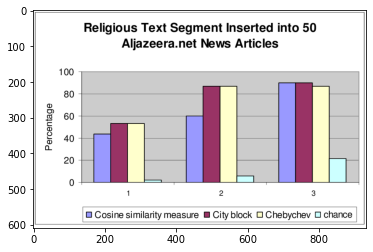

In [70]:
path = os.path.join("your_path_to_random_pictures_you_want_to_test")
import random
files = os.listdir(path)
file = "asdf"
channels = 0
while file[-3:] != "png" or channels != 4:
    file = random.choice(files)
    if file[-3:] == "png":
        img = io.imread(os.path.join("all_pics",file))
        channels = img.shape[-1]
    else:
        channels = 0

img = io.imread(os.path.join("all_pics",file))
ic(img.shape)
plt.imshow(img)

In [71]:
file

'L08-1316-Figure-5-3x.png'

{'width': 933,
 'height': 609,
 'chart type': 'bar_chart',
 'mark type': 'bar',
 'title': '',
 'encoding': {'x': {'field': '',
   'axis': {'title': ''},
   'type': 'quantitive',
   'scale': {'labels': ['1', '2', '3', 'a'],
    'values': [1.0, 2.0, 3.0],
    'domain': [1.0, 3.0],
    'range': [265.905, 783.7199999999999],
    'type': 'linear'}},
  'y': {'field': '',
   'axis': {'title': ''},
   'type': 'quantitive',
   'scale': {'labels': ['100', '80', '60', '40', '20', '0'],
    'values': [0.0, 20.0, 40.0, 60.0, 80.0, 100.0],
    'domain': [0.0, 100.0],
    'range': [173.10250000000002, 482.15875],
    'type': 'linear'}}}}

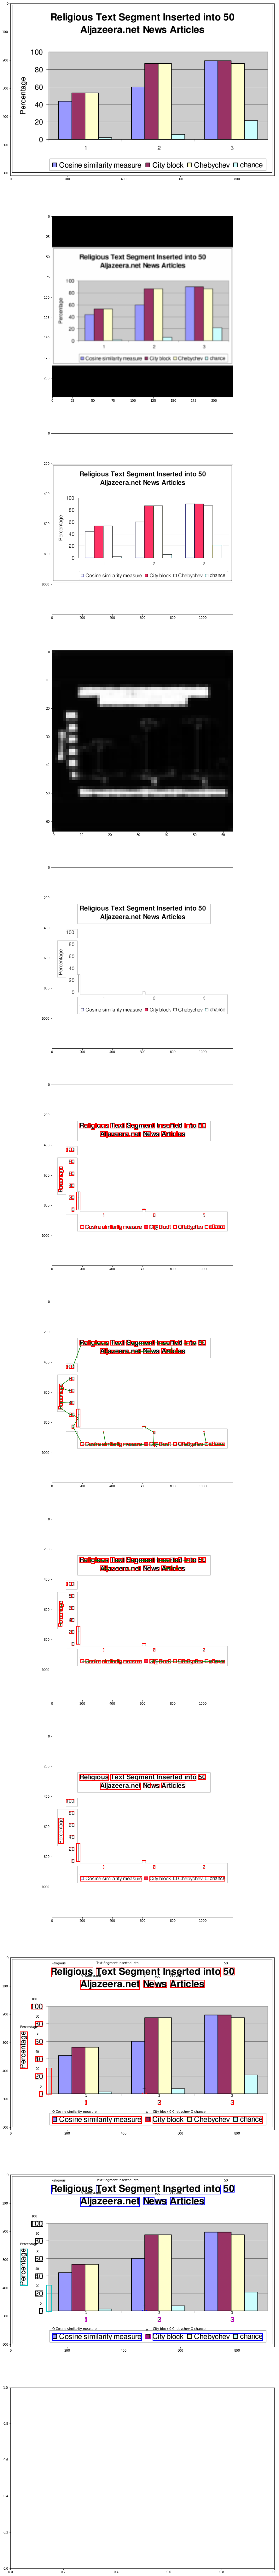

In [72]:
#a = get_specification(r"example_pictures\C02-1083-Figure-7-3x.png")
#a =get_specification(r"example_pictures\00025.png")
#a =get_specification(r"example_pictures\C02-1161-Figure-3-3x.png")

#file = 'I08-3008-Figure-3-3x.png'
a =get_specification(os.path.join("all_pics",file),True,contour_param = 0.2,contour_edge = np.inf)
a